# Install Dependencies

In [100]:
!pip install gensim
!pip install pyLDAvis

In [101]:
# General
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Sklearn
from sklearn.cluster import KMeans 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Enable logging for gensim - optional
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [102]:
FILENAME = "../data/processed_data/clear_text.txt"
TEST_FILENAME = "../data/processed_data/test_folder/unreadable.txt"
STOPWORDS_FILENAME = "../data/stopwords.txt"

SEED = 42

In [103]:
with open(FILENAME, "r") as file:
    voc = [i.split() for i in file.read().strip().split("\n")]

with open(FILENAME, "r") as file:
    voc_sklearn = file.read().split("\n")
    
with open(TEST_FILENAME, "r") as file:
    test = file.read()

with open(STOPWORDS_FILENAME, "r") as file:
    stopwords = file.read().strip().split()

---

# Scikit-Learn Realization

In [104]:
cv = CountVectorizer()
dataset = cv.fit_transform(voc_sklearn)
dataset

<645x35353 sparse matrix of type '<class 'numpy.int64'>'
	with 280763 stored elements in Compressed Sparse Row format>

In [105]:
lda = LDA(
    n_components = 10,
    max_iter=30,
    n_jobs=-1,
    learning_method='batch',
    verbose=1,
    random_state=SEED
)
lda.fit(dataset)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


LatentDirichletAllocation(max_iter=30, n_jobs=-1, random_state=42, verbose=1)

In [106]:
class TopicModeler(object):
    '''
    Inteface object for CountVectorizer + LDA simple
    usage.
    '''
    def __init__(self, count_vect, lda):
        '''
        Args:
             count_vect - CountVectorizer object from sklearn.
             lda - LDA object from sklearn.
        '''
        self.lda = lda
        self.count_vect = count_vect
        self.count_vect.input = 'content'

    def __call__(self, text):
        '''
        Gives topics distribution for a given text
        Args:
             text - raw text via python string.
        returns: numpy array - topics distribution for a given text.
        '''
        vectorized = self.count_vect.transform([text])
        lda_topics = self.lda.transform(vectorized)
        return lda_topics
    
    def get_keywords(self, text, n_topics=3, n_keywords=5):
        '''
        For a given text gives n top keywords for each of m top texts topics.
        Args:
             text - raw text via python string.
             n_topics - int how many top topics to use.
             n_keywords - how many top words of each topic to return.
        returns:
                list - of m*n keywords for a given text.
        '''
        lda_topics = self(text)
        lda_topics = np.squeeze(lda_topics, axis=0)
        n_topics_indices = lda_topics.argsort()[-n_topics:][::-1]

        top_topics_words_dists = []
        for i in n_topics_indices:
            top_topics_words_dists.append(self.lda.components_[i])

        shape=(n_keywords*n_topics, self.lda.components_.shape[1])
        keywords = np.zeros(shape=shape)
        for i,topic in enumerate(top_topics_words_dists):
            n_keywords_indices = topic.argsort()[-n_keywords:][::-1]
            for k,j in enumerate(n_keywords_indices):
                keywords[i * n_keywords + k, j] = 1
        keywords = self.count_vect.inverse_transform(keywords)
        keywords = [keyword[0] for keyword in keywords]
        return keywords  

In [107]:
tm = TopicModeler(cv, lda)

# Key words for test article
key_words = tm.get_keywords(" ".join(test), n_topics=1, n_keywords=10)
print(key_words)

['скорость', 'образец', 'жидкость', 'поток', 'зависимость', 'газ', 'уравнение', 'результат', 'исследование', 'значение']


In [108]:
# Compressing vocabulary data to 2D format for visualisation 

term_doc_matrix = cv.transform(voc_sklearn)
embeddings = lda.transform(term_doc_matrix)

kmeans = KMeans(n_clusters=30, random_state=SEED)
clust_labels = kmeans.fit_predict(embeddings)
clust_centers = kmeans.cluster_centers_

embeddings_to_tsne = np.concatenate((embeddings,clust_centers), axis=0)

tSNE =  TSNE(n_components=2, perplexity=15, random_state=SEED)
tsne_embeddings = tSNE.fit_transform(embeddings_to_tsne)
tsne_embeddings, centroids_embeddings = np.split(tsne_embeddings, [len(clust_labels)], axis=0)

In [109]:
print(tsne_embeddings.shape, centroids_embeddings.shape)

(645, 2) (30, 2)


In [110]:
clust_indices = np.unique(clust_labels)

clusters = {clust_ind : [] for clust_ind in clust_indices}
for emb, label in zip(tsne_embeddings, clust_labels):
    clusters[label].append(emb)

for key in clusters.keys():
    clusters[key] = np.array(clusters[key])
colors = cm.rainbow(np.linspace(0, 1, len(clust_indices)))

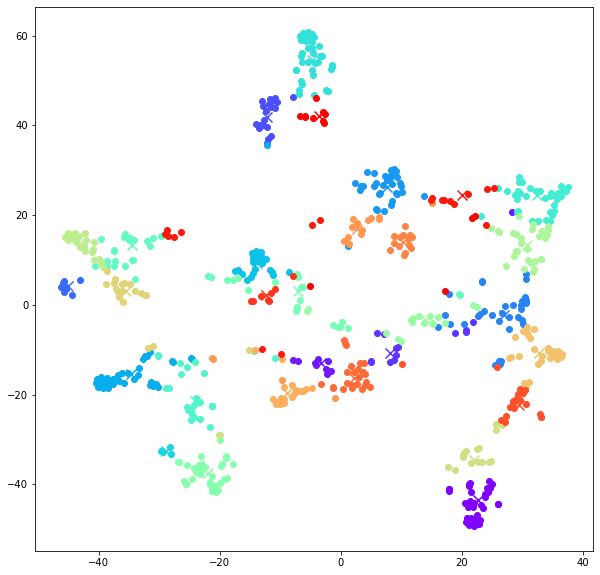

In [111]:
plt.figure(figsize=(10,10))
for ind, color in zip(clust_indices, colors):
    x = clusters[ind][:,0]
    y = clusters[ind][:,1]
    plt.scatter(x, y, color=color)
    
    centroid = centroids_embeddings[ind]
    plt.scatter(centroid[0],centroid[1], color=color, marker='x', s=100)

---

# Gensim Realization

In [112]:
id2word = corpora.Dictionary(voc)
texts = [test.split()]
corpus = [id2word.doc2bow(text) for text in texts]

In [113]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=10, 
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True,
    random_state=SEED
)

In [114]:
lda_model.print_topics()

[(0,
  '0.015*"почва" + 0.009*"загрязнение" + 0.008*"нефть" + 0.006*"нефтяной" + 0.006*"среда" + 0.006*"углеводород" + 0.005*"природный" + 0.004*"нефтепродукт" + 0.004*"ландшафт" + 0.004*"карта"'),
 (1,
  '0.000*"почва" + 0.000*"загрязнение" + 0.000*"нефть" + 0.000*"углеводород" + 0.000*"природный" + 0.000*"среда" + 0.000*"нефтепродукт" + 0.000*"нефтяной" + 0.000*"карта" + 0.000*"ландшафт"'),
 (2,
  '0.000*"почва" + 0.000*"загрязнение" + 0.000*"нефть" + 0.000*"нефтяной" + 0.000*"среда" + 0.000*"ландшафт" + 0.000*"углеводород" + 0.000*"природный" + 0.000*"техногенный" + 0.000*"нефтепродукт"'),
 (3,
  '0.000*"почва" + 0.000*"загрязнение" + 0.000*"нефть" + 0.000*"нефтяной" + 0.000*"углеводород" + 0.000*"среда" + 0.000*"природный" + 0.000*"ландшафт" + 0.000*"техногенный" + 0.000*"нефтепродукт"'),
 (4,
  '0.000*"почва" + 0.000*"загрязнение" + 0.000*"нефтяной" + 0.000*"нефть" + 0.000*"углеводород" + 0.000*"природный" + 0.000*"карта" + 0.000*"нефтепродукт" + 0.000*"ландшафт" + 0.000*"среда"')

In [115]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0     -0.138417  0.0       1        1  99.994949
3      0.015859 -0.0       2        1   0.000604
8      0.015816  0.0       3        1   0.000600
6      0.015815 -0.0       4        1   0.000599
7      0.015470 -0.0       5        1   0.000564
5      0.015436 -0.0       6        1   0.000561
4      0.015190  0.0       7        1   0.000543
2      0.015145  0.0       8        1   0.000540
1      0.014898 -0.0       9        1   0.000524
9      0.014789  0.0      10        1   0.000517, topic_info=              Term          Freq      Total Category  logprob  loglift
5580         почва  4.500000e+01  45.000000  Default  30.0000  30.0000
4390   загрязнение  2.600000e+01  26.000000  Default  29.0000  29.0000
203          нефть  2.400000e+01  24.000000  Default  28.0000  28.0000
204       нефтяной  1.700000e+01  17.000000  Default  27.0000  27.0000
1114   углеводород  1.600000e+01  16.000000  Default  26.0000  26.0000
...            ...           ...        ...      ...      ...      ...
3866        ун-тот  5.048579e-07   8.060728  Topic10 -10.3203  -4.4133
42         высокий  5.037819e-07   9.398765  Topic10 -10.3224  -4.5690
297          поток  4.967437e-07   6.280580  Topic10 -10.3365  -4.1800
814   устойчивость  4.984445e-07   8.956749  Topic10 -10.3331  -4.5315
916      компонент  4.941981e-07   7.169368  Topic10 -10.3416  -4.3175

[606 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
7893       1  1.028967     аккумуляция
852        1  1.011555        вещество
42         1  0.957573         высокий
11832      1  0.957717       география
5626       1  0.955820   геохимический
82         1  0.955653          добыча
4390       1  0.987699     загрязнение
107        1  0.975859            зона
1630       1  0.976226        источник
133        1  1.032476           карта
916        1  0.976376       компонент
924        1  1.028286    концентрация
8850       1  1.039201        ландшафт
1656       1  0.955299        миграция
21002      1  1.041024            моск
2354       1  1.038911    нефтепродукт
203        1  1.018633           нефть
204        1  1.008213        нефтяной
205        1  1.028810          низкий
619        1  0.928022         область
972        1  1.040765      окружающий
12290      1  1.028758           ореол
5578       1  1.016037       поллютант
297        1  0.955326           поток
5580       1  0.989709           почва
7543       1  1.015905       почвенный
1033       1  0.995181       природный
342        1  0.955657         процесс
351        1  1.005450       различный
354        1  0.958044           район
2423       1  1.011623       рассеяние
7260       1  1.040547    самоочищение
1950       1  1.057922            сера
1087       1  0.927892      содержание
1096       1  1.040582       состояние
1097       1  1.001289           среда
4211       1  0.983968      территория
2458       1  1.032716     техногенный
1114       1  1.001799     углеводород
1115       1  1.057830  углеводородный
3866       1  0.992466          ун-тот
430        1  0.928313         уровень
431        1  1.041100         условие
814        1  1.004829    устойчивость
2870       1  0.992247   экологический, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 9, 7, 8, 6, 5, 3, 2, 10])